Consider the [California Housing Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) that was studied in the lectures.

#### **(1) Data preprocessing:**  
Provide a proposal on how to improve data preprocessing relative to the procedure described in the lecture notes. Evaluate the impact of different data treatment algorithms on the OLS regression results using the full dataset. Leverage the code provided in lecture notes as much as you can/want. Motivate your choices and discuss the results.

In [2]:
# Import / install relevant Python packages
import numpy as np
import pandas as pd  
from scipy.special import comb
import datetime as dt
import statsmodels as sm

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import (SelectKBest, SelectPercentile, RFE, RFECV)

from sklearn.linear_model import (LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV)
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf                 # pip install yfinance

In [3]:
# Get data
from sklearn.datasets import fetch_california_housing
california_housing = fetch_california_housing()

In [4]:
# Quick scan of the dataset...
dir(california_housing)

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names']

In [5]:
# ... and then get more information 
print('Description:')
print(california_housing.DESCR)
print('-'*100)
print('Data:')
print(california_housing.data)
print(california_housing.data.shape)
print('-'*100)
print('Feature names:')
print(california_housing.feature_names)
print('-'*100)
print('Target:')
print(california_housing.target)
print('-'*100)

Description:
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This datase

In [6]:
# Create a dataframe
df_california_housing = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
df_california_housing['MedHouseVal'] = california_housing.target
df_california_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [7]:
duplicates = df_california_housing.groupby(['Latitude','Longitude'])['MedHouseVal'].size()
duplicates = duplicates[duplicates>1]
duplicates.sort_values()

Latitude  Longitude
32.56     -117.06       2
34.30     -118.71       2
          -118.70       2
          -118.45       2
34.31     -118.45       2
                       ..
37.75     -122.41      10
37.77     -122.43      10
37.80     -122.42      11
37.78     -122.44      11
37.80     -122.41      15
Name: MedHouseVal, Length: 4353, dtype: int64

Although there are no missing values, there are duplicate values for longitude and latitude attributes.
Since these seem to arise from rounding of long/lat numbers to two decimals, it would be in order to keep the data with duplicate longitude and latitude values.

In [8]:
# Display some basic statistics
df_california_housing.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Presumption is that the units of base income and house value are probably 10kUSD and 100kUSD, respectively.

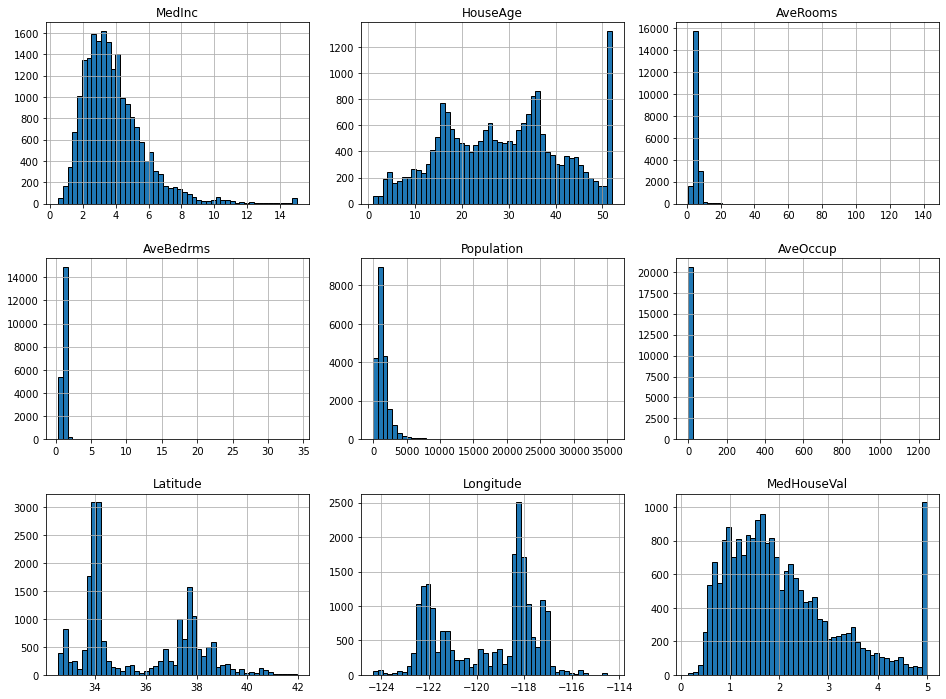

In [9]:
# Plot features
df_california_housing.hist(figsize=(16, 12), bins=50, edgecolor='black')
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

There are a few things in these histograms to observe:  
The attributes have rather different scales, so we should perform a feature scaling.  
Many histograms seem to be heavy tailed. 
The medium house value exhibits a sudden peak around 5.  
They seem to extend much further to the right from the median as opposed to the left.  
As it may make it a bit harder for Machine Learning algorithms to detect patterns, we would need to transform these to have more bell-shaped distributions, which can be obtained for skewed unimodal distributions by appropriate scaling, but for multimodal distributions it is not possible.

(array([3.566e+03, 8.587e+03, 4.757e+03, 1.826e+03, 8.890e+02, 4.220e+02,
        1.980e+02, 1.360e+02, 6.500e+01, 4.700e+01, 5.100e+01, 3.400e+01,
        1.200e+01, 1.400e+01, 1.300e+01, 5.000e+00, 3.000e+00, 1.000e+00,
        6.000e+00, 2.000e+00]),
 array([3.00000e+00, 6.65400e+02, 1.32780e+03, 1.99020e+03, 2.65260e+03,
        3.31500e+03, 3.97740e+03, 4.63980e+03, 5.30220e+03, 5.96460e+03,
        6.62700e+03, 7.28940e+03, 7.95180e+03, 8.61420e+03, 9.27660e+03,
        9.93900e+03, 1.06014e+04, 1.12638e+04, 1.19262e+04, 1.25886e+04,
        1.32510e+04]),
 <BarContainer object of 20 artists>)

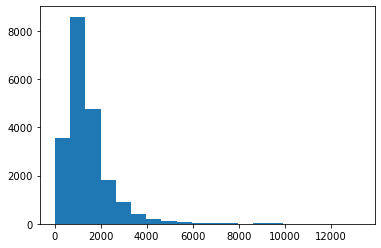

In [10]:
plt.hist(df_california_housing[df_california_housing.Population<15000].Population, bins=20) 

In [11]:
# Filter outliers
# AveRooms 12
# AveOccup 10
# AveBedrms 2
# Population 10_000
df_california_housing_manual = df_california_housing[(df_california_housing.Population<8_000) &
(df_california_housing.AveRooms<12) &
(df_california_housing.AveOccup<8) &
(df_california_housing.AveBedrms<2).copy() #&
#(df_california_housing.HouseAge<52) &
#(df_california_housing.MedHouseVal<5) 
]

print(f"Filtering outliers dropped {round(100*(1-df_california_housing_manual.__len__() / df_california_housing.__len__()),3)} % of data")

Filtering outliers dropped 1.715 % of data


By running manual inspection, we decide to filter out the data points with extreme values by certain dimensions.  
The following line plots histograms for individual variable, zoomed by filtering extreme values. After few iterations, we settled on the following upper bounds:
- AveRooms: 15
- AveOccup: 10
- AveBedrms: 3
- Population: 10.000

Dropping winzorized points with HouseAge=52 and MedHouseVal=5 drops approximately 11% of data, which we consider too restrictive, so no filtering by HouseAge and MedHouseVal is performed.

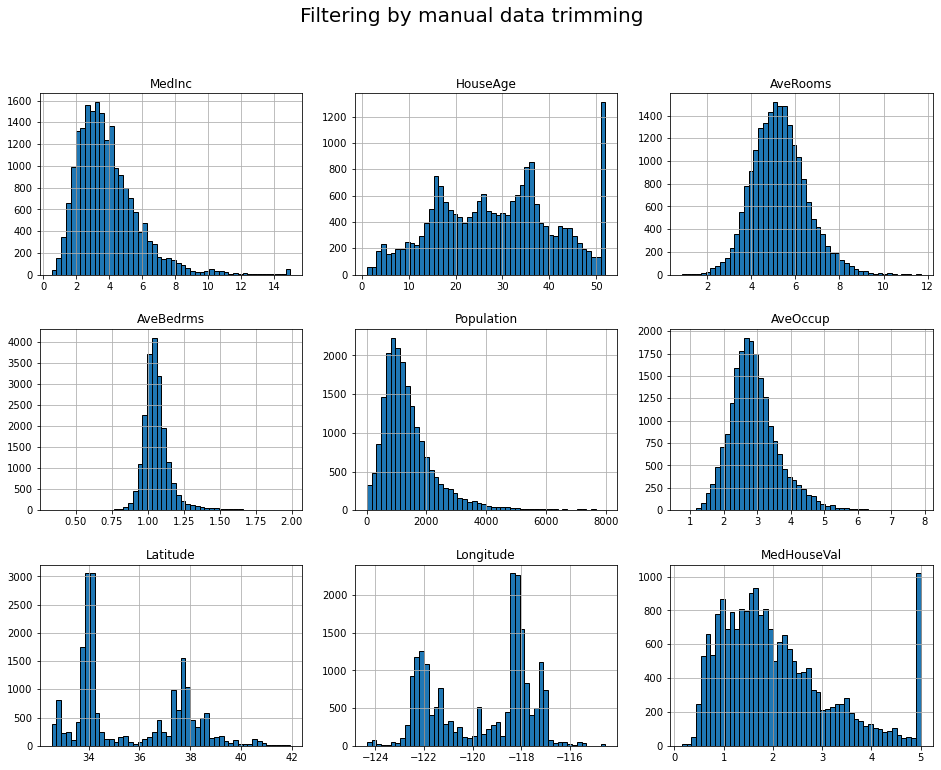

In [12]:
df_california_housing_manual.hist(figsize=(16, 12), bins=50, edgecolor='black')
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.suptitle('Filtering by manual data trimming',fontsize=20)
plt.show()

C:\Users\User\AppData\Local\Temp/ipykernel_14816/1073281401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_california_housing_manual['MedHouseVal'] = pd.qcut(df_california_housing_manual['MedHouseVal'], 4, retbins=False)
C:\Users\User\AppData\Local\Temp/ipykernel_14816/1073281401.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_california_housing_manual['MedHouseVal'] = df_california_housing_manual['MedHouseVal'].apply(lambda x: x.mid)


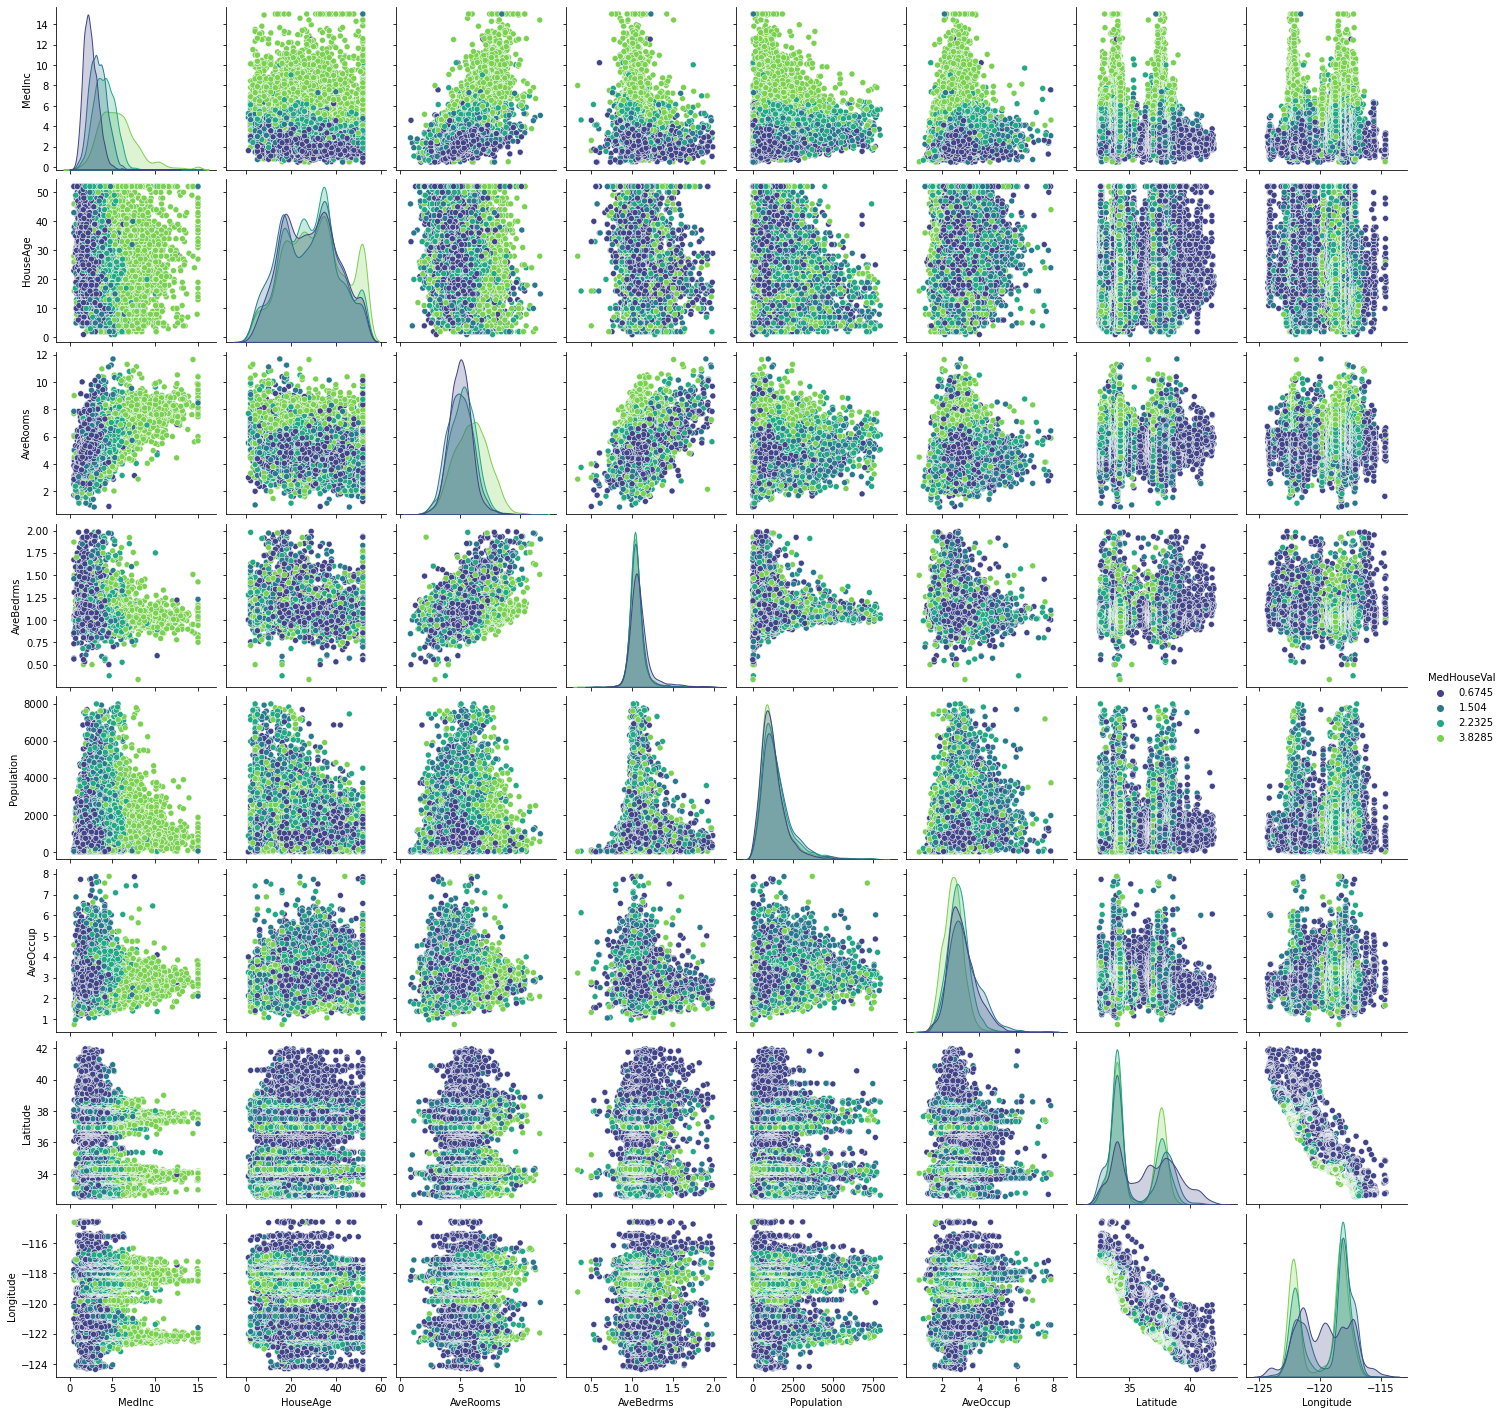

In [13]:
# Create pairwise plots
df_california_housing_manual['MedHouseVal'] = pd.qcut(df_california_housing_manual['MedHouseVal'], 4, retbins=False)
df_california_housing_manual['MedHouseVal'] = df_california_housing_manual['MedHouseVal'].apply(lambda x: x.mid)
sns.pairplot(data=df_california_housing_manual, hue='MedHouseVal', palette='viridis')
plt.show()

In [14]:
# util object for later looping
a=[]
for i in range(1,6):
    for j in range(1,3):
        a.append([j,i])
a=a[:-1]

fig = make_subplots(rows=5, cols=2)
a

[[1, 1], [2, 1], [1, 2], [2, 2], [1, 3], [2, 3], [1, 4], [2, 4], [1, 5]]

Instead of manual filtering, to be considered is filtering based on Mahalanobis distance, which is expected to take into account outliers as multivariate outliers instead of filtering dimension by dimension.

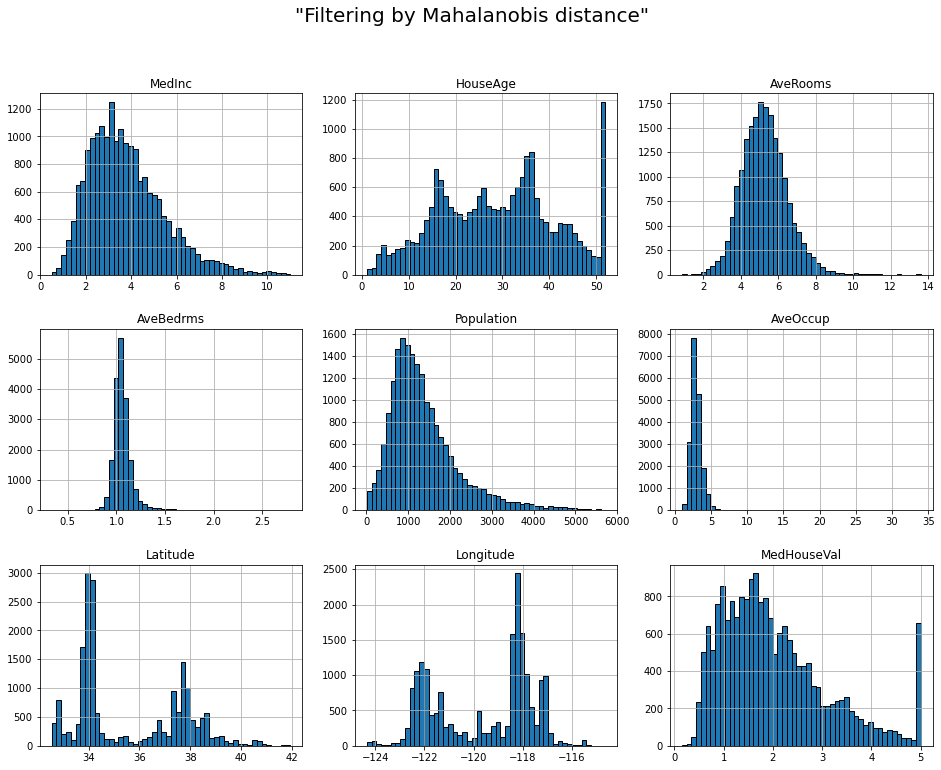

In [15]:
df_california_housing_mahalanobis = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
df_california_housing_mahalanobis['MedHouseVal'] = california_housing.target

# outliers removal and standard scaling
#since we are working with the multivariate data we will use mahalanobis distance to remove the outliers
from matplotlib.pyplot import title
from scipy.stats import chi2

def calculateMahalanobis(y=None, data=None, cov=None):
  
    y_mu = y - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(y_mu, inv_covmat)
    mahal = np.dot(left, y_mu.T)
    return mahal.diagonal()

df_california_housing_mahalanobis['Mahalanobis'] = calculateMahalanobis(y=df_california_housing_mahalanobis, data=df_california_housing_mahalanobis[list(df_california_housing_mahalanobis.columns)])
df_california_housing_mahalanobis['p'] = 1 - chi2.cdf(df_california_housing_mahalanobis['Mahalanobis'], 3)
df_california_housing_mahalanobis = df_california_housing_mahalanobis[df_california_housing_mahalanobis['p']>0.001].iloc[:,:-2]
df_california_housing_mahalanobis.hist(figsize=(16, 12), bins=50, edgecolor='black')
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.suptitle('"Filtering by Mahalanobis distance"',fontsize=20)
plt.show()

In [16]:
print(f"Filtering by Mahalanobis distance we dropped {round(100*(1-df_california_housing_mahalanobis.shape[0]/df_california_housing.shape[0]), 3)}% of data")

Filtering by Mahalanobis distance we dropped 5.673% of data


As seen from the plot, although filtering by Mahalanobis distance dropped more that 5% of data points, we failed to filter out outliers by AveOccup dimension.

In order for the preprocessing procedure to be applicable in the second task of the homework, we have to scale the dataset, which is necessary for LASSO, Ridge, Elastic net, etc.  
We will first split data into training and test data sets, and then we will scale training set using only data available to the training set. Parameters used for scaling will be saved and the same scaling procedure, with parameters of scaling from the training set, will be applied to the test set.

Since some features have multimodal distributions e.g., longitude, latitude, house age, splitting the data into training and test sets randomly could give us sets with unbalanced sampling of these variable. As we noticed from the lecture notes that Medium income is the most important variable, this variable should be sampled carefully. We will further compare random sampling with sampling that takes into account median values for resulting samples (training and test samples). 

Divide the data set to train/test and check level of 'MedInc' parameter, as it seems to be same in both original data set and train and test data sets

We add a new categorical feature in order to split the dataset properly:  
--Method 1: using the package train_test_split without the new feature  
--Method 2: using the package StratifiedShuffleSplit with the new feature 

(array([ 822.,    0., 6581.,    0.,    0., 7236.,    0., 3639.,    0.,
        2362.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

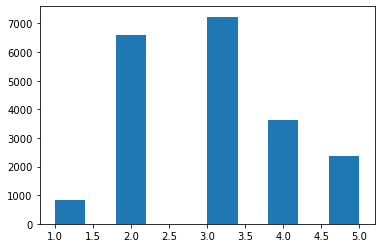

In [17]:
# split dataset by median income into five bins and plot histograms
data = df_california_housing.copy()
data['income_cat'] = np.ceil(data['MedInc']/1.5)
data['income_cat'].where(data['income_cat']<5, 5, inplace=True)
plt.hist(data.income_cat)

In [18]:
# count proportion of each bin in total dataset
data.income_cat.value_counts()/len(data.income_cat)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [19]:
# simple random sampling
from sklearn.model_selection import train_test_split
data4train, data4test = train_test_split(data, test_size=0.2, random_state=42)

# Stratified shuffle split samples in a way that final samples have similar distributions among strata
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state = 42)

for train_index, test_index in split.split(data, data['income_cat']):
    train_set = data.loc[train_index]
    test_set  = data.loc[test_index] 

def table4income_cat(dataset,df,label):
    df[label]=pd.Series(dataset['income_cat'].value_counts()/len(dataset['income_cat']))
    return df

df = pd.DataFrame()
df = table4income_cat(train_set,df,'All_set')
df = table4income_cat(train_set,df,'train_set_Shuff')
df = table4income_cat(test_set,df,'test_set_Shuff')
df = table4income_cat(data4train,df,'train_set_split')
df = table4income_cat(data4test,df,'test_set_split')
df

,All_set,train_set_Shuff,test_set_Shuff,train_set_split,test_set_split
3.0,0.350594,0.350594,0.350533,0.348595,0.358527
2.0,0.318859,0.318859,0.318798,0.317466,0.324370
4.0,0.176296,0.176296,0.176357,0.178537,0.167393
5.0,0.114462,0.114462,0.114341,0.115673,0.109496
1.0,0.039789,0.039789,0.039971,0.039729,0.040213


As seen from the table above, Stratified shuffle split did not make a significant improvement in balancing proportions of different strata. We will proceed with simple random splitting into training and test sets since.

We will check the OLS results following the outliers removal and scaling the data.

In [20]:
#Train test split data that has not been filtered manually or by mahalanobis for outliers
X_train, X_test, y_train, y_test = train_test_split(df_california_housing.drop("MedHouseVal", axis=1),
 df_california_housing.MedHouseVal, test_size=0.3, random_state=42)

# same for df_california_housing_mahalanobis and df_california_housing_filtered

In [21]:
#standard scaling 

std_x_scalar = StandardScaler().fit(X_train)
std_y_scalar = StandardScaler().fit(np.array(y_train).reshape(-1, 1))

In [22]:
x_train_scaled = std_x_scalar.transform(X_train)
x_test_scaled = std_x_scalar.transform(X_test)

y_train_scaled = std_y_scalar.transform(np.array(y_train).reshape(-1, 1))
y_test_scaled = std_y_scalar.transform(np.array(y_test).reshape(-1, 1))

In [23]:
ols = LinearRegression().fit(x_train_scaled, y_train_scaled)
ols.coef_

array([[ 7.33699101e-01,  1.05506985e-01, -2.58808447e-01,
         3.01014265e-01, -7.64168065e-04, -3.60257061e-02,
        -7.72261284e-01, -7.50455668e-01]])

In [24]:
ols.score(x_train_scaled, y_train_scaled)

0.6093459727972159

In [25]:
ols.score(x_test_scaled, y_test_scaled)

0.5957702326061664

In [26]:
from sklearn.metrics import r2_score

def fit_models(data_frame):
    # split
    X_train, X_test, y_train, y_test = train_test_split(data_frame.drop("MedHouseVal", axis=1), data_frame.MedHouseVal, test_size=0.3, random_state=42)
    
    # scale
    std_x_scalar = StandardScaler().fit(X_train)
    std_y_scalar = StandardScaler().fit(np.array(y_train).reshape(-1, 1))

    x_train_scaled = std_x_scalar.transform(X_train)
    x_test_scaled = std_x_scalar.transform(X_test)

    y_train_scaled = std_y_scalar.transform(np.array(y_train).reshape(-1, 1))
    y_test_scaled = std_y_scalar.transform(np.array(y_test).reshape(-1, 1))

    # fit
    ols = LinearRegression().fit(x_train_scaled, y_train_scaled)

    R2_train = ols.score(x_train_scaled, y_train_scaled)
    R2_test = ols.score(x_test_scaled, y_test_scaled)

    def adjr2(r2, rowcount, featurecount):
        """ R2 Score """
        return 1-(1-r2)*(rowcount-1)/(rowcount-featurecount)

    adjR2_train = adjr2(R2_train, x_train_scaled.shape[0], x_train_scaled.shape[1])
    adjR2_test = adjr2(R2_test, x_test_scaled.shape[0], x_train_scaled.shape[1])


    return ols.coef_,  adjR2_train , adjR2_test

In [27]:
preprocessed_sets = [df_california_housing_mahalanobis, df_california_housing_manual, df_california_housing]

results = [fit_models(set) for set in preprocessed_sets]
names = ["Mahalanobis", "Manual", "No outlier filtering"]
r2s_train = [res[1] for res in results]
r2s_test = [res[2] for res in results]

pd.DataFrame({"Name": names, "adj. R2 train": r2s_train, "adj. R2 test": r2s_test})

,Name,adj. R2 train,adj. R2 test
0,Mahalanobis,0.681585,0.695711
1,Manual,0.592694,0.595828
2,No outlier filtering,0.609157,0.595313


As seen from the table above, not filtering outliers results in much smaller adjusted $R^2$. If we want to apply filtering, we should opt for filtering based on Mahalanobis distance rather than manual filtering.

In [28]:
coefs = [res[0] for res in  results]

fig=go.Figure()

fig.add_trace(go.Scatter(y=coefs[2][0],x=df_california_housing.columns[:-1],name='No filtering of outliers'))
fig.add_trace(go.Scatter(y=coefs[1][0],x=df_california_housing_manual.columns[:-1],name='Manual filtering of outliers'))
fig.add_trace(go.Scatter(y=coefs[0][0],x=df_california_housing_mahalanobis.columns[:-1],name='Filtering by Mahalanobis dist.'))

From the plot, we see that importance of different features are similar for all three regression. Still, some features like AveOccup, AveRooms and AveBadrooms gained or loss importance by switching from one preprocessing to another.

#### **(2) Feature and model selection:**  
* Using your final (transformed) dataset, split the full sample into training and
testing subsamples. Evaluate in-sample and out-of-sample performance for the
following models: OLS, PLS, rigde, lasso, and elastic net regressions. For models
which do not embed a feature selection procedure, consider specifications with
different numbers of features. You can use performance metric(s) of your choice,
however provide a rationale for your preferred approach.  
* Create a summary tables and charts that displays different model specifications
and the corresponding in-sample and out-of-sample performance metrics. Discuss
your findings and comment on pros and cons for each of the considered models.  
* Draw a conclusion which features are most important and which models perform
best, and discuss your results.

In the previous task we concluded that filtering based on Mahalanobis distance is the optimal filtering. We will preprocess data using Mahalanobis filtering and split scaled data into test and training sets.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_california_housing_mahalanobis.drop(
    "MedHouseVal", axis=1), df_california_housing_mahalanobis.MedHouseVal, test_size=0.3, random_state=42)

# scale
std_x_scalar = StandardScaler().fit(X_train)
std_y_scalar = StandardScaler().fit(np.array(y_train).reshape(-1, 1))

x_train_scaled = std_x_scalar.transform(X_train)
x_test_scaled = std_x_scalar.transform(X_test)

y_train_scaled = std_y_scalar.transform(np.array(y_train).reshape(-1, 1))
y_test_scaled = std_y_scalar.transform(np.array(y_test).reshape(-1, 1))

In [30]:
from sklearn.feature_selection import SelectKBest
import numpy as np
from sklearn.feature_selection import f_regression


X=x_train_scaled
y=y_train_scaled

BestFeatures = SelectKBest(score_func=f_regression,k=8)
fit = BestFeatures.fit(X,y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(df_california_housing_mahalanobis.columns[:-1])

f_Scores = pd.concat([df_columns,df_scores],axis=1)               # feature scores
f_Scores.columns = ['Specs','Score']  

correlations = pd.DataFrame(np.abs([np.corrcoef(y.T[0], X[:, i])[0, 1] for i in range(
    8)]), index=df_california_housing_mahalanobis.columns[:-1], columns=['Correlation coef'])

correlations['Specs'] = correlations.index
c = correlations.reset_index(drop=True).copy()

f_Scores.set_index("Specs").join(c.set_index("Specs")).sort_values('Score', ascending=False)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



,Score,Correlation coef
Specs,,
MedInc,13670.289957,0.707680
AveRooms,1515.272894,0.316347
AveOccup,865.316466,0.244362
Latitude,243.207348,0.132423
AveBedrms,141.148577,0.101255
HouseAge,129.122427,0.096888
Longitude,32.091463,0.048473
Population,11.134267,0.028574


Check the OLS results with different number of features.

In [31]:
x_train_scaled 
x_test_scaled
y_train_scaled 
y_test_scaled 

array([[ 0.87903821],
       [-0.18324832],
       [-1.38433535],
       ...,
       [ 0.78742987],
       [-0.8106266 ],
       [-0.11662408]])

In [32]:
x_train_scaled[:, [1,2,3]]

array([[ 0.80918569,  2.33181702,  0.14915626],
       [ 0.24159787,  1.41256957,  1.69881442],
       [ 0.24159787, -0.4910053 , -0.38731751],
       ...,
       [-1.70441749,  0.26349978, -0.32701529],
       [ 0.1605139 ,  0.65965827,  0.0326058 ],
       [ 1.62002542,  0.04276737, -0.15530492]])

In [33]:
def fit_models(model,  columns=None):
    x_train, y_train, x_test, y_test = x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled
    model = model.fit(x_train[:, columns], y_train)
    R2_train = model.score(x_train[:, columns], y_train)
    R2_test = model.score(x_test[:, columns], y_test)

    def adjr2(r2, rowcount, featurecount):
        """ R2 Score """
        return 1-(1-r2)*(rowcount-1)/(rowcount-featurecount)

    adjR2_train = adjr2(R2_train, x_train[:, columns].shape[0], x_train[:, columns].shape[1])
    adjR2_test = adjr2(R2_test, x_test[:, columns].shape[0], x_train[:, columns].shape[1])

    return adjR2_train, adjR2_test

In [34]:
# ols with top three features
ols3 = LinearRegression()#.fit(x_train_scaled[0, 2, 5], y_train)


# ols with top four features
ols4 = LinearRegression()#.fit(x_train_scaled[0, 2, 5, 6], y_train)

# ols with all features 
ols8 = LinearRegression()#.fit(x_train_scaled, y_train)

OLS_res = [fit_models(model, columns=cols) for model, cols in zip([ols3, ols4, ols8], [[0, 2, 5], [0, 2, 5, 6], [0, 1, 2, 3, 4, 5, 6, 7]])]


In [35]:
df = pd.DataFrame(OLS_res, columns = ["Train R2", "Test R2"], index = ["top 3 vars", "top 4 vars", "all variables"])
df

,Train R2,Test R2
top 3 vars,0.575491,0.582309
top 4 vars,0.579637,0.587822
all variables,0.681585,0.695711


Since OLS performance doesn't change from training to test sets, we don't need to impose additional penalty terms in order to use Ridge, Lasso, or Elastic net. Furthermore, in Hiperparameter tuning we expect optimal alpha to be close to zero

In [36]:
X_train_ridge, y_train_ridge, X_test_ridge, y_test_ridge = x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled

ridge = Ridge(alpha=1)
ridge.fit(X_train_ridge, y_train_ridge)
ridge.score(X_train_ridge, y_train_ridge), ridge.score(X_test_ridge,y_test_ridge)

(0.6817487328745273, 0.6960662264409455)

In [37]:
from sklearn.linear_model import RidgeCV

# Lasso with 5 fold cross-validation
model_ridge = RidgeCV(cv=5,alphas=(0.1, 10, 100, 1000))

# Fit model
model_ridge.fit(X_train_ridge, y_train_ridge)

RidgeCV(alphas=array([1.e-01, 1.e+01, 1.e+02, 1.e+03]), cv=5)

In [38]:
model_ridge.alpha_

0.1

In [39]:
ridge_opt=Ridge(alpha=model_ridge.alpha_)
ridge_opt.fit(X_train_ridge, y_train_ridge)
print('R squared training set', round(ridge_opt.score(X_train_ridge, y_train_ridge)*100, 2))
print('R squared test set', round(ridge_opt.score(X_test_ridge, y_test_ridge)*100, 2))

R squared training set 68.17
R squared test set 69.61


Small optimal value of alpha creates the similar fit like in OLS.

In [40]:
from sklearn.linear_model import Lasso
X_train_lasso,  y_train_lasso, X_test_lasso, y_test_lasso = x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled

reg = Lasso(alpha=0.1)
reg.fit(X_train_lasso, y_train_lasso)

print('R squared training set', round(reg.score(X_train_lasso, y_train_lasso)*100, 2))
print('R squared test set', round(reg.score(X_test_lasso, y_test_lasso)*100, 2))

R squared training set 54.72
R squared test set 54.84


We see that already with alpha equal to one our coefficients shrinks to zero and consequently model has a very poor fit. Based on this we can antcipate that optimal apha will be between 0 and 1, so the ridge coefficients won't be that much different from OLS.

In [42]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model_lasso = LassoCV(cv=5,alphas=(0.001,0.1, 10, 100, 1000))

# Fit model
model_lasso.fit(X_train_ridge, y_train_ridge)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LassoCV(alphas=(0.001, 0.1, 10, 100, 1000), cv=5)

In [43]:
# Set best alpha
lasso_best = Lasso(alpha=model_lasso.alpha_)
lasso_best.fit(X_train_lasso, y_train_lasso)

Lasso(alpha=0.001)

In [44]:
print('R squared training set', round(lasso_best.score(X_train_lasso, y_train_lasso)*100, 2))
print('R squared test set', round(lasso_best.score(X_test_lasso, y_test_lasso)*100, 2))

R squared training set 68.17
R squared test set 69.57


Model is a good fit in both training and test samples. However, like in ridge we lasso coef are rather same as in OLS.

In [45]:
from sklearn.model_selection import cross_val_score 

from sklearn.model_selection import RepeatedKFold
model = ElasticNet(alpha=1.0, l1_ratio=0.5) 

X_train_net,y_train_net, X_test_net, y_test_net =  x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled


model.fit(X_train_net, y_train_net)

print('R squared training set', round(model.score(X_train_net, y_train_net)*100, 2))
print('R squared test set', round(model.score(X_test_net, y_test_net)*100, 2))

R squared training set 17.68
R squared test set 17.43


Alpha of 1 decreases fit signifficantly in comparrison to OLS. We would expect optimal alpha to be close to zero.

In [46]:
enet_cv_model = ElasticNetCV(cv = 10).fit(X_train_net,y_train_net)
# Let's create the final model according to optimum alpha.

enet_tuned = ElasticNet(alpha = enet_cv_model.alpha_).fit(X_train_net,y_train_net)


enet_cv_model.alpha_

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.0014153604228320082

Optimal alpha is close to zero.

In [47]:
print('R squared training set', round(enet_tuned.score(X_train_net, y_train_net)*100, 2))
print('R squared test set', round(enet_tuned.score(X_test_net, y_test_net)*100, 2))

R squared training set 68.17
R squared test set 69.57


In [48]:
#PLS

# Set number of components
no_components = 4


X_train_PLS,y_train_PLS,X_test_PLS, y_test_PLS = x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled



# Instantiate PLS model
pls_estimator = PLSRegression(n_components = 4)

# Train PLS model
pls_california_housing = pls_estimator.fit_transform(X_train_PLS, y_train_PLS)


y_train_pred_PLS = pls_estimator.predict(X_train_PLS)
y_test_pred_PLS = pls_estimator.predict(X_test_PLS)

#cross validation
cv_scores = cross_val_score(pls_estimator,X_train_PLS, y_train_PLS, cv=10)

cross_validate(pls_estimator,X_train_PLS, y_train_PLS,return_estimator=True, n_jobs=1, cv=10)

{'fit_time': array([0.0219903 , 0.02098989, 0.02398777, 0.02798772, 0.02498245,
        0.02398849, 0.02898383, 0.02998567, 0.02898216, 0.02698851]),
 'score_time': array([0.00199676, 0.00199652, 0.00199723, 0.00199723, 0.0010004 ,
        0.00199676, 0.00199866, 0.00199723, 0.00099969, 0.00099707]),
 'estimator': [PLSRegression(n_components=4),
  PLSRegression(n_components=4),
  PLSRegression(n_components=4),
  PLSRegression(n_components=4),
  PLSRegression(n_components=4),
  PLSRegression(n_components=4),
  PLSRegression(n_components=4),
  PLSRegression(n_components=4),
  PLSRegression(n_components=4),
  PLSRegression(n_components=4)],
 'test_score': array([0.66310609, 0.66934137, 0.64666119, 0.64500549, 0.61254844,
        0.68119278, 0.65139518, 0.66110521, 0.67575825, 0.6494554 ])}

In order to find the optimal number of components we will start with all 8 variables and then see how does the $R^2$ changes

In [50]:
#finding out the optimal number of components

from sklearn.cross_decomposition import PLSRegression
my_plsr = PLSRegression(n_components=8)
my_plsr.fit(X_train_PLS, y_train_PLS)

PLSRegression(n_components=8)

In [51]:
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


eror=[]

for n_comp in range(1, 9):
    my_plsr = PLSRegression(n_components=n_comp, scale=True)
    my_plsr.fit(X_train_PLS, y_train_PLS)
    preds = my_plsr.predict(X_test_PLS)
    eror.append(sqrt(mean_squared_error(y_test_PLS ,preds)))

In [52]:

from sklearn.metrics import r2_score
r2=[]
best_r2 = 0
best_ncmop = 0
for n_comp in range(1, 9):
    my_plsr = PLSRegression(n_components=n_comp)
    my_plsr.fit(X_train_PLS, y_train_PLS)
    preds = my_plsr.predict(X_test_PLS)

    r2.append(r2_score(y_test_PLS,preds))

r2

[0.4961130400861331,
 0.5946676073842028,
 0.6554773879242031,
 0.6754835886953099,
 0.6839208840772895,
 0.6855746348555531,
 0.6943982467666594,
 0.6960762136542791]

We will add addititional number of components and plot it. The optimal number of components will be once the decrease of $R^2$ becomes maximal upon adding additonal component.

In [53]:
import plotly.graph_objects as go

fig=go.Figure()

fig.add_trace(go.Scatter(y=eror,x=list(range(1,9))))

According to the elbow method optimal would be to choose 3 components, since after the fourth component the curve gets flatter.

Similar procedure can be done with the $R^2$ . We are going to stop with adding the variables, as soon as the contribution of an additonal variable becomes negligible.

In [54]:
j=0
for i in [j-i for i, j in zip(r2[:-1], r2[1:])]:
    if i>np.mean([j-i for i, j in zip(r2[:-1], r2[1:])]):
        j+=1
    elif i<np.mean([j-i for i, j in zip(r2[:-1], r2[1:])]):
        break
print(f'Optimum {j+1} and the r2 {r2[j]}')

Optimum 3 and the r2 0.6554773879242031


In [55]:
import sklearn.metrics as sm
print("R2 score training  =", round(sm.r2_score(y_train_PLS,
y_train_pred_PLS), 2))
print("R2 score testing =", round(sm.r2_score(y_test_PLS, y_test_pred_PLS), 2))


#very similar score in taining and testing means that the model is a good fit

R2 score training  = 0.66
R2 score testing = 0.68


Due to the same in and out of sample fit, there is no need to impose the penalty term, so OLS is better than Ridge, Lasso and Elastic net. However, between OLS and PLS (Partial Least Squares), more prefered is PLS, due to the fact that PLS removes multicolineariry, which should be checked by using VIF (Variance Inflation Factor).

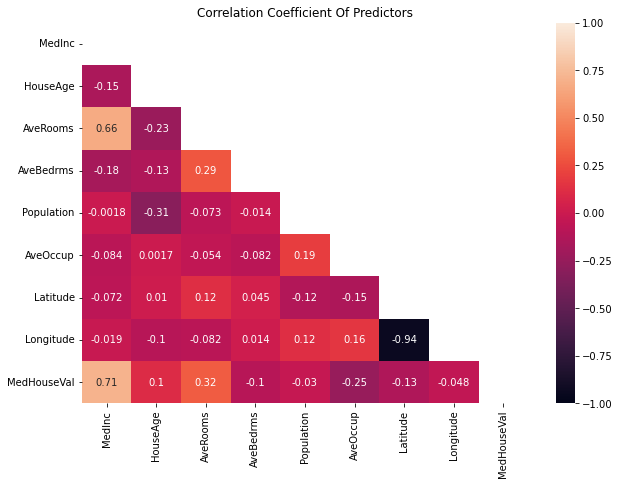

In [56]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns

# set figure size
plt.figure(figsize=(10,7))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(df_california_housing_mahalanobis.corr(), dtype=bool))

# generate heatmap
sns.heatmap(df_california_housing_mahalanobis.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

Obviously Latitude and Longitude are highly correlated, which is due to a geographical shape of California coast line, and two biggest cities LA and Silicon Valley. Hence introduction of Longitude while we already have latitude doesn't produce an improvent at all. Furthermore we see that $\rho$ of -0.15 between latitude and Avg occupied makes unique contrbution of latitude negligible (as seen once we compared OLS with 3 most important variable vs OLS with 4 most imortant variables).

In [57]:
# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    
    X = df_california_housing_mahalanobis.iloc[:,considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [58]:
compute_vif(list(range(0,8))).sort_values('VIF', ascending=False)

,Variable,VIF
6,Latitude,11.899721
7,Longitude,11.321536
0,MedInc,3.314746
2,AveRooms,3.311072
3,AveBedrms,1.590430
1,HouseAge,1.303539
4,Population,1.201590
5,AveOccup,1.097662


In [60]:
dfreg= pd.DataFrame(OLS_res, columns = ["Train R2", "Test R2"], index = ["top 3 vars", "top 4 vars", "all variables"])

dfreg.iloc[2,:][0], dfreg

(0.6815852743836248,
                Train R2   Test R2
 top 3 vars     0.575491  0.582309
 top 4 vars     0.579637  0.587822
 all variables  0.681585  0.695711)

In [61]:
df=pd.DataFrame([[ridge_opt.score(X_train_ridge, y_train_ridge),ridge_opt.score(X_test_ridge, y_test_ridge),model_ridge.alpha_],[lasso_best.score(X_train_lasso, y_train_lasso),lasso_best.score(X_test_lasso, y_test_lasso),model_lasso.alpha_],[enet_tuned.score(X_train_net, y_train_net),enet_tuned.score(X_test_net, y_test_net),enet_cv_model.alpha_],[sm.r2_score(y_train_PLS,y_train_pred_PLS),sm.r2_score(y_test_PLS,y_test_pred_PLS),''],[
dfreg.iloc[2,:][0],dfreg.iloc[2,:][1],'']])


df.index=['ridge','lasso','elastic net','PLS','regression']

df.columns=['insample r2','out of sample r2','alpha']
df

,insample r2,out of sample r2,alpha
ridge,0.681749,0.696075,0.1
lasso,0.681710,0.695714,0.001
elastic net,0.681695,0.695702,0.001415
PLS,0.657482,0.675484,
regression,0.681585,0.695711,


PLS is the ultimate winner due to no problems with multicolinearity.